#**# 3**

토마토가 채소일 확률 측정

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

food = pd.read_csv('https://www.dropbox.com/s/ry9t14zj8fwdwtq/food_samples.csv?dl=1')
tomato = pd.read_csv('https://www.dropbox.com/s/kk1qscljxe5kb7x/tomato.csv?dl=1')

food_input = (food[['단백질(g)', '지질(g)', '탄수화물(g)', '총당류(g)', '나트륨(mg)', '콜레스테롤(mg)', '총 포화 지방산(g)', '트랜스 지방산(g)']]).to_numpy()
food_target = food['식품상세분류'].to_numpy()
tomato_input = (tomato[['단백질(g)', '지질(g)', '탄수화물(g)', '총당류(g)', '나트륨(mg)', '콜레스테롤(mg)', '총 포화 지방산(g)', '트랜스 지방산(g)']]).to_numpy()

train_input, test_input, train_target, test_target = train_test_split(food_input, food_target, random_state=42)

scaler = StandardScaler()
scaler.fit(train_input)
train_scaled_input = scaler.transform(train_input)
test_scaled_input = scaler.transform(test_input)
scaled_tomato = scaler.transform(tomato_input)


LogiReg = LogisticRegression(C=100)
LogiReg.fit(train_scaled_input, train_target)
proba = LogiReg.predict_proba(scaled_tomato)

for i in range(len(tomato)):
  if LogiReg.predict(scaled_tomato)[i] == '채소류':
    type_name = '채소'
    probability = np.round(proba[i][1],decimals=6)
  else:
    type_name = '과일'
    probability = np.round(proba[i][0],decimals=6)

  print("%s = %s : %f"%(tomato['식품명'][i],type_name,probability))

토마토, 생것 = 채소 : 0.831487
토마토, 데친것 = 채소 : 0.695281
토마토, 통조림 = 채소 : 0.745364
토마토, 방울토마토, 생것 = 채소 : 0.757057
토마토, 유기재배, 생것 = 채소 : 0.830487
토마토, 흑토마토, 생것 = 채소 : 0.642852
토마토, 흑토마토, 데친것 = 채소 : 0.654358
토마토, 대저, 생것 = 채소 : 0.697696
토마토, 대저, 데친것 = 채소 : 0.721642
토마토, 과채 음료 = 과일 : 0.829885
토마토 페이스트 = 채소 : 0.998571
토마토, 퓨레, 통조림 = 채소 : 0.939400


# **# 5.**

첨부된 titanic_train데이터와 titanic_test 데이터를 다운받고 4장에서 배웠던 LogisticRegression과 SGD를 이용하여 타이타닉 사고 때 생존한 사람들을 예측해보는 모델을 만들어라.

1. LogisticRegression(로지스틱 회귀)
2. SGD(확률적 경사 하강법)

# 0. 공통

1) 데이터 불러오기

2) 각 칼럼과 생존과의 관계 파악

3) 데이터 전처리, 결측치 해결

In [ ]:
# 데이터 불러오기

# 구글 코랩 <-> 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
titanic_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SAI 문제풀이/titanic_test.csv')
titanic_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SAI 문제풀이/titanic_train.csv')

titanic_test.info()
titanic_train.info()
titanic_test.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  -----

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# 각 칼럼과 생존과의 관계 파악
# 1. Pclass(좌석 등급) : Pclass별로 group화 하여, Survived의 평균값을 구하기
titanic_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

### 관계가 있어보임 !

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
# 2. Sex(성별) :
titanic_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

### 관계가 있어보임 !

,Sex,Survived
0,female,0.742038
1,male,0.188908


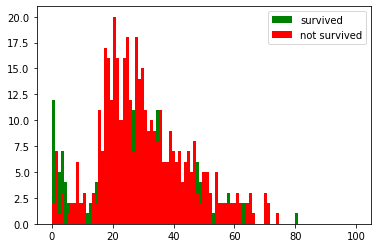

In [ ]:
# 3. Age(나이)
import matplotlib.pyplot as plt
import numpy as np

survived = titanic_train[titanic_train['Survived'] == 1]
not_survived = titanic_train[titanic_train['Survived'] == 0]

plt.hist(survived['Age'],bins=np.linspace(0,100,100),color='g')
plt.hist(not_survived['Age'],bins=np.linspace(0,100,100),color='r')
plt.legend(['survived','not survived'])
plt.show()

In [ ]:
# 4. SibSp(형제, 자매, 부부 동승 유무)
titanic_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
# 5. Parch(부모, 자식 동승 유무)
titanic_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


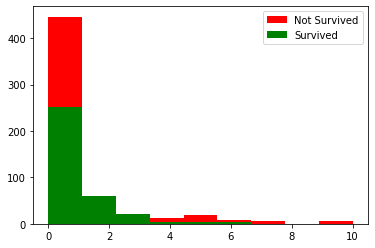

In [ ]:
# 6. SibSp + Parch (부양가족)
survived = titanic_train[titanic_train['Survived'] == 1]
not_survived = titanic_train[titanic_train['Survived'] == 0]

plt.hist(not_survived['SibSp']+not_survived['Parch'],bins=np.linspace(0,10,10),color='r')
plt.hist(survived['SibSp']+survived['Parch'],bins=np.linspace(0,10,10),color='g')
plt.legend(['Not Survived','Survived'])
plt.show()

### 관계가 있어보임 !?

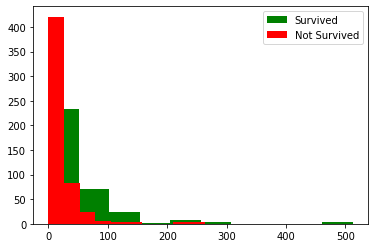

In [ ]:
# 7. Fare(가격)
titanic_train[["Fare", "Survived"]].groupby(["Fare"], as_index=False).mean().sort_values(by='Survived', ascending=False)

survived = titanic_train[titanic_train['Survived'] == 1]
not_survived = titanic_train[titanic_train['Survived'] == 0]

plt.hist(survived['Fare'],color='g')
plt.hist(not_survived['Fare'],color='r')
plt.legend(['Survived','Not Survived'])
plt.show()
### 애매

In [ ]:
# 8. Embarked(탑승지)
titanic_train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

### 관계가 있어보임 !

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [ ]:
# 새로 필드 추가
titanic_train['Family'] = (titanic_train['SibSp']+titanic_train['Parch'])
titanic_test['Family'] = (titanic_test['SibSp']+titanic_test['Parch'])

# 필요없는 필드 삭제
titanic_train = titanic_train.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis=1)
titanic_test = titanic_test.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis=1)

titanic_train

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0
887,1,1,female,19.0,30.0000,S,0
888,0,3,female,NaN,23.4500,S,3
889,1,1,male,26.0,30.0000,C,0


In [ ]:
# train data 결측치 개수 확인
titanic_train.isnull().sum()

# Embarked 결측치 삭제
titanic_train.dropna(subset=['Embarked'],inplace=True)

titanic_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
Embarked      0
Family        0
dtype: int64

In [ ]:
# test data 결측치 개수 확인
titanic_test.isnull().sum()

# Fare 결측치 삭제
titanic_test.dropna(subset=['Fare'],inplace=True)

titanic_test.isnull().sum()

Pclass       0
Sex          0
Age         86
Fare         0
Embarked     0
Family       0
dtype: int64

In [ ]:
# 데이터 병합 : index를 순서대로
data = pd.concat((titanic_train,titanic_test),ignore_index = True)

data

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0.0,3,male,22.0,7.2500,S,1
1,1.0,1,female,38.0,71.2833,C,1
2,1.0,3,female,26.0,7.9250,S,0
3,1.0,1,female,35.0,53.1000,S,1
4,0.0,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...,...
1301,NaN,3,male,NaN,8.0500,S,0
1302,NaN,1,female,39.0,108.9000,C,0
1303,NaN,3,male,38.5,7.2500,S,0
1304,NaN,3,male,NaN,8.0500,S,0


In [ ]:
# 결측치 확인
data.isnull().sum()

Survived    417
Pclass        0
Sex           0
Age         263
Fare          0
Embarked      0
Family        0
dtype: int64

In [ ]:
# Sex 매핑
sexMap = {"male" : 0, "female" : 1}
data['Sex'] = data['Sex'].map(sexMap)

# Embarked 매핑
embarkedMap = {"C" : 0,"Q" : 1, "S" : 2}
data["Embarked"] = data["Embarked"].map(embarkedMap)

# Age 결측치를 중앙값으로 채움
data['Age'].fillna(data["Age"].median(), inplace=True)

data

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0.0,3,0,22.0,7.2500,2,1
1,1.0,1,1,38.0,71.2833,0,1
2,1.0,3,1,26.0,7.9250,2,0
3,1.0,1,1,35.0,53.1000,2,1
4,0.0,3,0,35.0,8.0500,2,0
...,...,...,...,...,...,...,...
1301,NaN,3,0,28.0,8.0500,2,0
1302,NaN,1,1,39.0,108.9000,0,0
1303,NaN,3,0,38.5,7.2500,2,0
1304,NaN,3,0,28.0,8.0500,2,0


In [ ]:
# 다시 train data와 test data로 나누기
data_train = data.iloc[0:889]
data_test = data.iloc[889:1306]

data_train_input = (data_train[['Pclass',	'Sex',	'Age',	'Fare',	'Embarked',	'Family']]).to_numpy()
data_train_target = (data_train['Survived']).to_numpy()
data_test_input = (test_set[['Pclass',	'Sex',	'Age',	'Fare',	'Embarked',	'Family']]).to_numpy()

# 표준화 전처리
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_set_input)
data_train_scaled_input = scaler.transform(data_train_input)
data_test_scaled_input = scaler.transform(data_test_input)

# 1. Logistic Regression

1) train 데이터 이용해서 test 데이터의 'Survived' 채우기

2) train 데이터와 test 데이터 합친 전체 data

3) train set과 test set으로 split하기

4) train set와 test set의 Logistic Regression score 확인

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(data_train_scaled_input, data_train_target)
data_test_pred = lr.predict(data_test_scaled_input)
data['Survived'][889:1306] = data_test_pred

data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0.0,3,0,22.0,7.2500,2,1
1,1.0,1,1,38.0,71.2833,0,1
2,1.0,3,1,26.0,7.9250,2,0
3,1.0,1,1,35.0,53.1000,2,1
4,0.0,3,0,35.0,8.0500,2,0
...,...,...,...,...,...,...,...
1301,0.0,3,0,28.0,8.0500,2,0
1302,1.0,1,1,39.0,108.9000,0,0
1303,0.0,3,0,38.5,7.2500,2,0
1304,0.0,3,0,28.0,8.0500,2,0


In [ ]:
data_input = (data[['Pclass',	'Sex',	'Age',	'Fare',	'Embarked',	'Family']]).to_numpy()
data_target = (data['Survived']).to_numpy()

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state=42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# 다중 분류 모델 훈련
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))


0.8580183861082737
0.8623853211009175


# 2. Stochastic Gradient Descent

1) train 데이터 이용해서 test 데이터의 'Survived' 채우기

2) train 데이터와 test 데이터 합친 전체 data

3) train set과 test set으로 split하기

4) train set와 test set의 SGD score 확인

In [ ]:
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log',max_iter=10,random_state=42)
sc.fit(data_train_scaled_input, data_train_target)
data_test_pred = sc.predict(data_test_scaled_input)
data['Survived'][889:1306] = data_test_pred

data

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0.0,3,0,22.0,7.2500,2,1
1,1.0,1,1,38.0,71.2833,0,1
2,1.0,3,1,26.0,7.9250,2,0
3,1.0,1,1,35.0,53.1000,2,1
4,0.0,3,0,35.0,8.0500,2,0
...,...,...,...,...,...,...,...
1301,0.0,3,0,28.0,8.0500,2,0
1302,1.0,1,1,39.0,108.9000,0,0
1303,0.0,3,0,38.5,7.2500,2,0
1304,0.0,3,0,28.0,8.0500,2,0


In [ ]:
data_input = (data[['Pclass',	'Sex',	'Age',	'Fare',	'Embarked',	'Family']]).to_numpy()
data_target = (data['Survived']).to_numpy()

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state=42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# 다중 분류 모델 훈련
sc = SGDClassifier(loss='log', max_iter=100,random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8192032686414709
0.8256880733944955


# **# 5 문제 바뀜..**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# 데이터 불러오기
## 구글 코랩 <-> 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')
titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SAI 문제풀이/titanic_train.csv')
titanic.info()

# 데이터 정리
## Age의 결측치에 평균값 넣기
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)
## Embarked의 결측치에 제일 많은 'S' 넣기
print(titanic['Embarked'].describe())
titanic['Embarked'].fillna('S', inplace=True)
## 입력 데이터와 타깃 데이터 나누기
titanic_input = titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
titanic_target = (titanic['Survived']).to_numpy()
## 원핫인코딩으로 문자를 숫자로 바꾸기
titanic_input = (pd.get_dummies(titanic_input)).to_numpy()

# 표준화
train_input, test_input, train_target, test_target = train_test_split(titanic_input, titanic_target)
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# 점수 확인
print('LogisticRegression')
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

print('SGD')
sgd = SGDClassifier(loss = 'log')
sgd.fit(train_scaled, train_target)
print(sgd.score(train_scaled, train_target))
print(sgd.score(test_scaled, test_target))

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
LogisticRegression
0.8143712574850299
0.7802690582959642
SGD
0.8008982035928144
0.7847533632286996
